# ECON 0150 | Replication Notebook

**Title:** Mortgage Rates and Home Prices

**Original Authors:** Zheng; Li

**Original Date:** Fall 2025

---

This notebook replicates the analysis from a student final project in ECON 0150: Economic Data Analysis.

## About This Replication

**Research Question:** Do U.S. mortgage interest rates affect home prices?

**Data Source:** FRED - 30-Year Fixed Rate Mortgage (MORTGAGE30US) and Case-Shiller Home Price Index (CSUSHPINSA)

**Methods:** OLS regression: Home_Price_Index ~ Mortgage_Rate

**Main Finding:** Negative correlation between mortgage rates and home prices, but interpretation requires careful consideration of economic conditions.

**Course Concepts Used:**
- Time series data
- Data merging
- Simple linear regression
- Correlation vs. causation

---
## Step 0 | Setup

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [3]:
# Load data from course website
file_path = 'https://tayweid.github.io/econ-0150/projects/replications/0006/data/'

mortgage = pd.read_csv(file_path + 'MORTGAGE30US.csv')
housing = pd.read_csv(file_path + 'CSUSHPINSA.csv')

print(f"Mortgage data: {len(mortgage)} observations")
print(f"Housing data: {len(housing)} observations")
print()
print("Mortgage data:")
print(mortgage.head())

Mortgage data: 2854 observations
Housing data: 465 observations

Mortgage data:
  observation_date  MORTGAGE30US
0       1971-04-02          7.33
1       1971-04-09          7.31
2       1971-04-16          7.31
3       1971-04-23          7.31
4       1971-04-30          7.29


---
## Step 1 | Data Preparation

In [3]:
# Convert dates
mortgage['date'] = pd.to_datetime(mortgage['observation_date'])
housing['date'] = pd.to_datetime(housing['observation_date'])

# Mortgage data is weekly, housing is monthly - resample mortgage to monthly
mortgage['year_month'] = mortgage['date'].dt.to_period('M')
housing['year_month'] = housing['date'].dt.to_period('M')

# Monthly average mortgage rate
mortgage_monthly = mortgage.groupby('year_month')['MORTGAGE30US'].mean().reset_index()
mortgage_monthly.columns = ['year_month', 'Mortgage_Rate']

# Rename housing column
housing = housing.rename(columns={'CSUSHPINSA': 'Home_Price_Index'})

print(f"Monthly mortgage data: {len(mortgage_monthly)} observations")

Monthly mortgage data: 657 observations


In [4]:
# Merge datasets
data = pd.merge(mortgage_monthly, housing[['year_month', 'Home_Price_Index']], 
                on='year_month', how='inner')

# Convert period back to datetime for plotting
data['date'] = data['year_month'].dt.to_timestamp()

print(f"\nMerged data: {len(data)} observations")
print(f"Date range: {data['date'].min().strftime('%Y-%m')} to {data['date'].max().strftime('%Y-%m')}")
data.head()


Merged data: 465 observations
Date range: 1987-01 to 2025-09


,year_month,Mortgage_Rate,Home_Price_Index,date
0,1987-01,9.2040,63.733,1987-01-01
1,1987-02,9.0825,64.132,1987-02-01
2,1987-03,9.0350,64.468,1987-03-01
3,1987-04,9.8325,64.972,1987-04-01
4,1987-05,10.5960,65.547,1987-05-01


---
## Step 2 | Data Exploration

In [5]:
# Summary statistics
print("Summary Statistics:")
print(data[['Mortgage_Rate', 'Home_Price_Index']].describe())

Summary Statistics:
       Mortgage_Rate  Home_Price_Index
count     465.000000        465.000000
mean        6.344006        151.261886
std         2.114779         71.884020
min         2.684000         63.733000
25%         4.427500         83.530000
50%         6.352500        144.080000
75%         7.682500        183.641000
max        11.260000        331.671000


In [6]:
# Correlation
correlation = data['Mortgage_Rate'].corr(data['Home_Price_Index'])
print(f"\nCorrelation between mortgage rate and home price index: {correlation:.4f}")


Correlation between mortgage rate and home price index: -0.5628


---
## Step 3 | Visualization

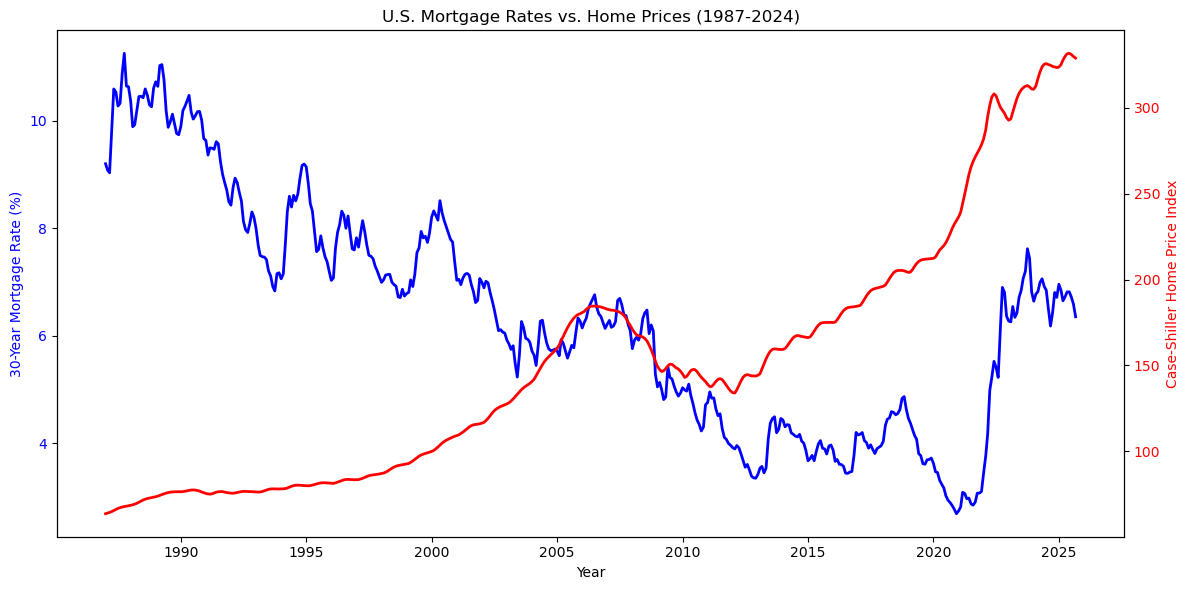

In [7]:
# Time series plot with dual axes
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['date'], data['Mortgage_Rate'], 'b-', linewidth=2, label='Mortgage Rate')
ax1.set_xlabel('Year')
ax1.set_ylabel('30-Year Mortgage Rate (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(data['date'], data['Home_Price_Index'], 'r-', linewidth=2, label='Home Prices')
ax2.set_ylabel('Case-Shiller Home Price Index', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('U.S. Mortgage Rates vs. Home Prices (1987-2024)')
fig.tight_layout()
plt.show()

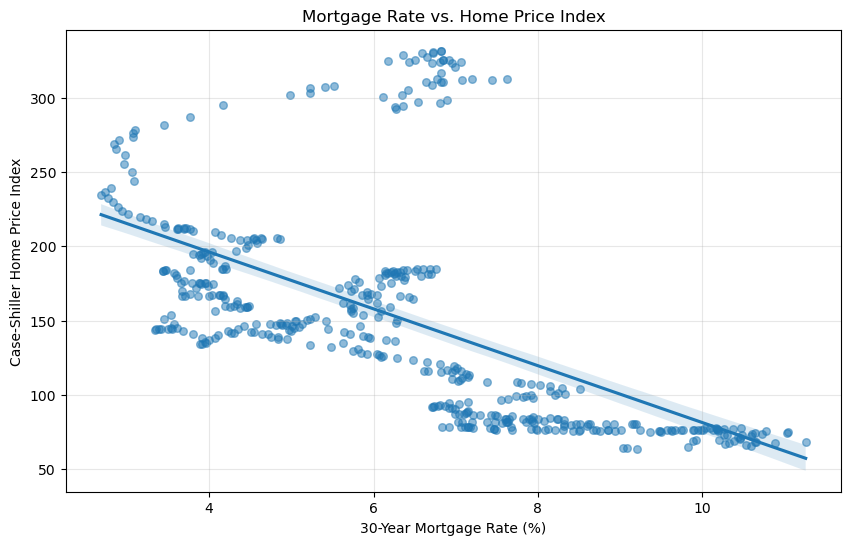

In [8]:
# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='Mortgage_Rate', y='Home_Price_Index', data=data,
            scatter_kws={'s': 30, 'alpha': 0.5})
plt.title('Mortgage Rate vs. Home Price Index')
plt.xlabel('30-Year Mortgage Rate (%)')
plt.ylabel('Case-Shiller Home Price Index')
plt.grid(True, alpha=0.3)
plt.show()

---
## Step 4 | Statistical Analysis

In [9]:
# OLS Regression
model = smf.ols('Home_Price_Index ~ Mortgage_Rate', data=data).fit()
print("OLS Regression: Home_Price_Index ~ Mortgage_Rate")
print(model.summary())

OLS Regression: Home_Price_Index ~ Mortgage_Rate
                            OLS Regression Results                            
Dep. Variable:       Home_Price_Index   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     214.7
Date:                Tue, 03 Feb 2026   Prob (F-statistic):           3.27e-40
Time:                        11:08:44   Log-Likelihood:                -2558.6
No. Observations:                 465   AIC:                             5121.
Df Residuals:                     463   BIC:                             5130.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [10]:
# Key results
print("\n" + "="*50)
print("KEY RESULTS")
print("="*50)
print(f"\nNull Hypothesis: Mortgage rates do not affect home prices (beta = 0)")
print(f"\nModel Results:")
print(f"  Intercept: {model.params['Intercept']:.2f}")
print(f"  Mortgage Rate coefficient: {model.params['Mortgage_Rate']:.3f}")
print(f"  P-value: {model.pvalues['Mortgage_Rate']:.6f}")
print(f"  R-squared: {model.rsquared:.3f}")
print(f"\nInterpretation:")
print(f"  Each 1 percentage point increase in mortgage rate is associated")
print(f"  with a {model.params['Mortgage_Rate']:.2f} point change in the home price index")


KEY RESULTS

Null Hypothesis: Mortgage rates do not affect home prices (beta = 0)

Model Results:
  Intercept: 272.63
  Mortgage Rate coefficient: -19.132
  P-value: 0.000000
  R-squared: 0.317

Interpretation:
  Each 1 percentage point increase in mortgage rate is associated
  with a -19.13 point change in the home price index


---
## Step 5 | Results Interpretation

### Key Findings

1. **Negative Correlation:** Higher mortgage rates are associated with lower home prices

2. **Economic Theory:** This makes sense - higher borrowing costs reduce housing demand

3. **Time Series Concern:** Both variables have strong trends over time (home prices trending up, rates trending down since 1980s)

### Causation Warning

The relationship is complicated:
- **Rates → Prices:** Higher rates reduce affordability, lowering demand and prices
- **Prices → Rates:** The Fed may raise rates when housing markets overheat
- **Third variables:** Economic conditions affect both (recessions lower rates AND prices)

### Historical Context

- **1980s:** Rates above 10%, prices relatively low
- **2008 Crisis:** Rates cut to help housing market
- **2020s:** Record low rates fueled price surge, then rate hikes to cool market

### What Would Be Needed?

- First-differences analysis to remove trends
- Lagged effects (rate changes take time to affect prices)
- Regional analysis (different markets respond differently)

---
## Replication Exercises

### Exercise 1: First Differences
Regress changes in home prices on changes in mortgage rates. Does the relationship hold?

### Exercise 2: Lagged Analysis
Do this month's rates predict next month's (or next quarter's) home prices?

### Exercise 3: Subperiod Analysis
Split the data into pre-2008 and post-2008. Is the relationship different?

### Challenge Exercise
Research the Fed's dual mandate. How does monetary policy affect housing markets?

In [ ]:
# Your code for exercises

# Example: First differences analysis
# data['Price_Change'] = data['Home_Price_Index'].diff()
# data['Rate_Change'] = data['Mortgage_Rate'].diff()
# model_diff = smf.ols('Price_Change ~ Rate_Change', data=data.dropna()).fit()
# print(model_diff.summary().tables[1])